In [ ]:
# Problem Set 1 (97 points) 

## Important information
We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

# Problem 1 (Time series forecasting with simple NLA) (31 pts)

Many daily-life events can be described using **time series**: $x_t$, $t \in \{0, \ldots, n\}$, e.g.
closing price of a stock on day $t$ or number of users on a website in hour $t$.

Below you are given time series example $x \in \mathbb{R}^n$:

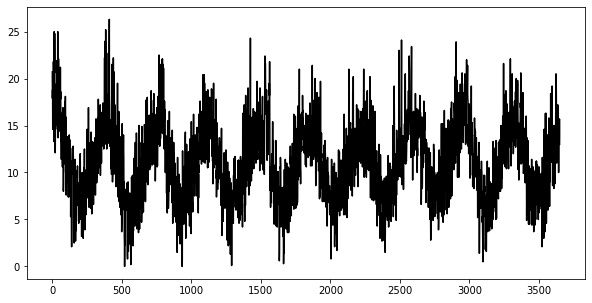

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('./data.csv')
x = data['Val']
plt.figure(figsize=(10, 5))
plt.plot(x, c='k')
plt.show()

Raw time dependent data usually looks rather unpretty. However, it can be often considered as a sum of some **trend** + some random **noise**. For example, a periodic trend is easily observed in the series above.

_1._ Your first task is to find **truly** periodic series which will best approximate the original data $x$.

Let $z \in \mathbb{R}^m$ denotes one period of some given periodic data $x_{per} \in \mathbb{R}^n$ (assuming $n$ is miltiple of $m$), i.e.:

$$x_{per} = (z,z,\ldots,z),$$

or in the matrix form:

$$Az = x_{per},$$

with "tall" matrix $A \in \mathbb{R}^{n\times m}$, $n > m$.

The actual data $x$ is non-periodic, hence the solution (in appropriate sense) of the following **overdetermined** linear system is required (think why):

$$Az = x.$$

- (3 pts) Choose $m$ and implement function to construct matrix $A$ according to the template below. What structure does this matrix have?
 *Hint:*  you can use ```numpy.vstack()``` function. Describe how do you choose $m$. Also, suggest what are the data you are working with?

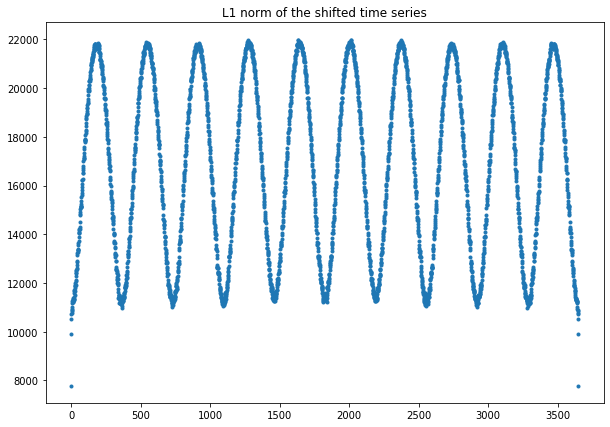

In [65]:
import numpy as np

x = np.array(x).reshape(-1, 1)

x_shifted_diff = np.array([np.abs(x - np.roll(x, shift)).sum() for shift in range(1, x.shape[0])])
plt.figure(figsize=(10, 7))
plt.title('L1 norm of the shifted time series')
plt.plot(x_shifted_diff, marker='.', linestyle='')
plt.show()

In [66]:
m_val = np.sort(np.argsort(x_shifted_diff[100:1500])[:6])
print(m_val)
print(m_val[3] - m_val[1], m_val[-1] - m_val[3])

[265 266 626 627 634 993]
361 366


Seems like we are working with a time series, where observations were obtained each day and so we can see a period of one year = 365 days

In [67]:
m = 365
x.shape[0], m

(3650, 365)

We want the z[0] to occure at positions x[0], x[m], x[2m] ... Therefore A is looking like 10 vertically stacked identity matricies of size m 

In [68]:
def build_A(n, m):
    '''
    Input: positive integers n, m
    Output: np.array of size (n, m)
    '''
    # Pure loops are strongly prohibited! 
    # Comprehension expressions are possible.
    assert n > m
    stack_rate = n // m
#     raise NotImplementedError()
    init_matrix = np.eye(m, dtype=float)
    return np.vstack([init_matrix] * 10)

A = build_A(x.shape[0], m) 

- (3 pts) Find the best periodic approximation $z^*$ as the solution of the above overdetermined linear system. Below you are supposed to compute **pseudo-inverse** of $A$ (by definition) according to the provided template.

In [69]:
def build_pseudoinverse(A):
    '''
    Input: np.array of size (n, m)
    Output: np.array of size (m, n)
    '''
    u, s, vh = np.linalg.svd(A, full_matrices=False, compute_uv=True)
    u, vh = np.matrix(u), np.matrix(vh)
    s_plus = np.array([1 / sigma if sigma else 0 for sigma in s])
    return vh.H @ np.diag(s_plus) @ u.H


A_inv = build_pseudoinverse(A)
z = A_inv @ x

- (1 pts) Plot the original data $x$ and the periodic data $Az^*$ in one plot. Do not forget to add a proper legend!

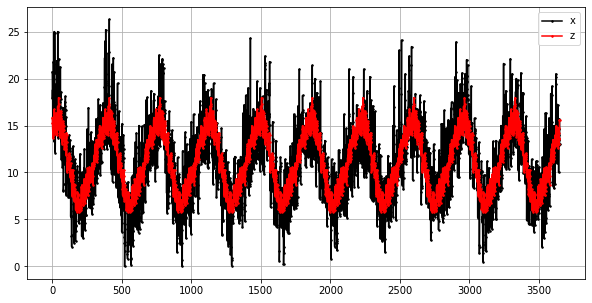

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(x, c='k', label='x', marker='.', markersize=3)
plt.plot(A @ z, c='r', label='z', marker='.', markersize=3)
plt.legend()
plt.grid()
# Place for your plots

If your solution is correct, you see that the obtained periodic approximation is **non-smooth**.

To ensure the smoothness in our periodic approximation, consider the following **regularized** least-squares problem:

$$L(z) = ||Az - x||^2 + \lambda R(z) \to \min_z ,$$

where $R(z)$ is some regularization term and $\lambda > 0$.
The term $R(z)$ reflects our additional assumptions on the smoothness of the periodic approximation $z$. One of the possible form of this term is:

$$ R(z) = \sum_{i=1}^m (z_{i+1} - z_i)^2.$$

Another form of the same regularization term is:

$$R(z) =  \|Dz\|_2^2.$$

Intuitevely, the regularization term aims to penalize "sharp" series, and the parameter $\lambda$ provides a trade-off between approximation quality (the first term) and the smoothness degree (the second term). Note, the case $\lambda = 0$ corresponds to the previously obtained solution $z^*$ (why?).
 



_2._ Your second task is to find the best **smooth** periodic approximation $z^*_s$ of the original data $x$.

- (5 pts) Implement function to construct matrix $D$ according to the template provided below. Don't forget about periodicity! What is the meaning of $D$?

In [71]:
def build_D(m):
    '''
    Input: positive integer m
    Output: np.array of size (m, m)
    '''
    D = - np.eye(m, dtype=float) + np.eye(m, k=1, dtype=float)
    D[-1,0] = 1
    return D


D = build_D(z.shape[0])
D

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0., -1.]])

- (3 pts) The optimality condition for the ordinary least-squares problem was derived during the lecture course. Using the same technique, for a given $\lambda$ derive an analog of the **normal equation** for the regularized least-squares problem formulated above.

The optimality condition is $0\equiv \nabla \left(\|Az-x\|_2^2 + \lambda\|Dz\|_2^2 \right)$, where $\nabla$ denotes gradient. Therefore,

$$ 0 \equiv \nabla \left(\|Az-x\|_2^2 + \lambda\|Dz\|_2^2\right) = 2(A^*A z - A^*x + \lambda D^*Dz) = 0. $$

Thus,

$$ \quad (A^* A + \lambda D^*D)z = A^* x $$

- (1 pts) Solve the derived system. You are supposed to use previously constructed matrices $A$ and $D$.

In [72]:
lmbda = 1e4 # You are supposed to play with parameter $\lambda$ during your study

# Construct system
A, D = np.matrix(A, dtype=float), np.matrix(D, dtype=float)
matrix = A.H @ A + lmbda * D.H @ D
rhs = A.H @ x
# matrix.shape, rhs.shape
z_s = np.linalg.solve(matrix, rhs)

- (2 pts) Plot the original data $x$ and smooth periodic approximation $Az^*_s$ for three increasing values of $\lambda$. You have to get three plots with two time series $x$ and $Az^*_s$ in every plot. How $\lambda$ affects plots?

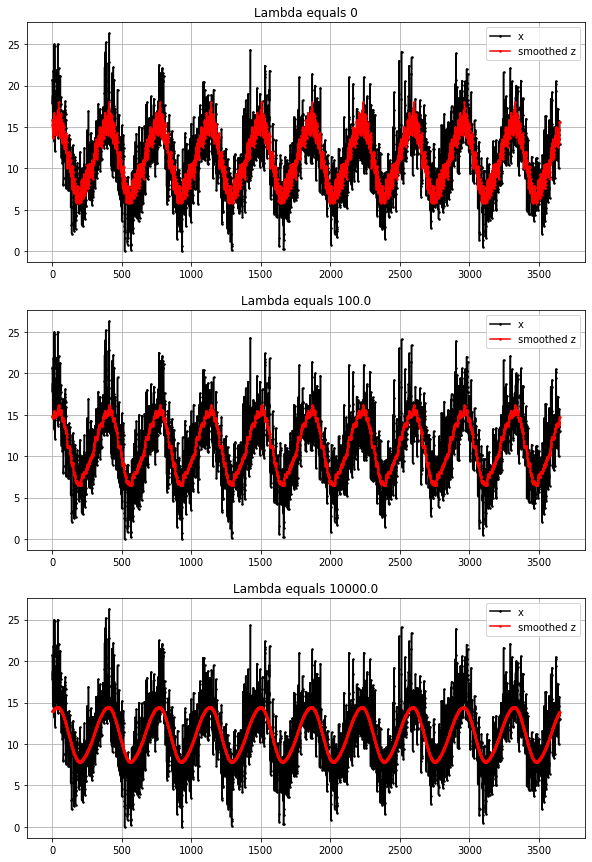

In [73]:
# Your solution is here
fig, ax = plt.subplots(3, 1, figsize=(10, 5 * 3))

for i, l in enumerate([0, 1e2, 1e4]):
    matrix = A.H @ A + l * D.H @ D
    rhs = A.H @ x
    z_s = np.linalg.solve(matrix, rhs)
    
    ax[i].set_title(f'Lambda equals {l}')
    ax[i].plot(x, c='k', label='x', marker='.', markersize=3)
    ax[i].plot(A @ z_s, c='r', label='smoothed z', marker='.', markersize=3)
    ax[i].legend()
    ax[i].grid()
plt.show()

The bigger $\lambda$ is, the smoother is our approximation.

_3._ The final step is to build a model for predicting time series.

_-_ We want to predict $x_{k+1}$ based on $M$ previous observations.

_-_ Consider the following (linear) auto-regression (AR) model:

$$\hat{x}_{k+1} = \theta_1 x_k + \theta_2 x_{k-1} + \ldots + \theta_M x_{k-M+1},$$

with $M$ parameters $\theta_1, \ldots, \theta_M$ to be determined.

_-_ We fit the parameters by minimizing squared norm of the residual (again!):
    
$$(\hat{x}_{M+1} - x_{M+1})^2 + \ldots + (\hat{x}_n - x_n)^2 \to \min_{\mathbf{\theta}}.$$
    
_-_ This problem can be reformulated in a familiar form:

$$||X\theta - \tilde{x}||_2^2 \to \min_{\theta},$$

where $\tilde{x} = [x_{M+1}, x_{M+2}, \ldots, x_n]$.

- (7 pts) Implement function that constructs matrix $X \in \mathbb{R}^{(n-M) \times M}$ according to the template below. What structure does it have? Use appropriate function from ```NumPy/SciPy``` stack. 


In [75]:
def build_X(x, M):
    '''
    Input: np.array of size n, positive integer M
    Output: np.array of size (n - M, M)
    '''  
    X = [np.roll(x, -i)[:M] for i in range (x.shape[0] - M)]
    return np.vstack(X)
    
# build_X(np.array([1, 2, 3, 4, 5]), 2)

Note, that the previously obtained smooth periodic approximation $z_s$ by itself can be regarded as a predictive model. However, we want to include the noise term in the model too, by fitting it with AR model:

In [76]:
#reconstruct better smoothing
matrix = A.H @ A + 1e4 * D.H @ D
rhs = A.H @ x
# matrix.shape, rhs.shape
z_s = np.linalg.solve(matrix, rhs)

In [79]:
x_n = np.array(x - A @ z_s).reshape(-1) # Extract noise
train_x = x_n[:x_n.shape[0] // 2] #  Train data to fit the model
test_x = x_n[x_n.shape[0] // 2:] #  Test data to validate the model
M = 10 # You are supposed to find the best parameter $M$ during your study
X_train = build_X(train_x, M)

- (3 pts) Once you constructed $X$ based on the training data, the fitting of the parameters $\theta$ again requires the solution of the linear least-squares problem. This time you are supposed to compute pseudoinverse of $X$ via QR decomposition. Hint: use ```numpy.linalg.qr()``` function.

In [80]:
def build_pseudoinverse_QR(A):
    '''
    Input: np.array of size (n - M, M)
    Output: np.array of size (M, n - M)
    '''  
    q, r = np.linalg.qr(A)
    q, r = np.matrix(q), np.matrix(r)
    return np.linalg.inv(r) @ q.H

X_inv = build_pseudoinverse_QR(X_train)
theta = X_inv @ train_x[M:]

- (3 pts) Check your model with test data. Plot your predicted noise series and test noise series in one plot. Next, add smooth trend $Az_s$ back to predicted noise series and plot it with the original series $x$ in one plot. You have to get two plots with two time series in every plot. Be careful with indexing!

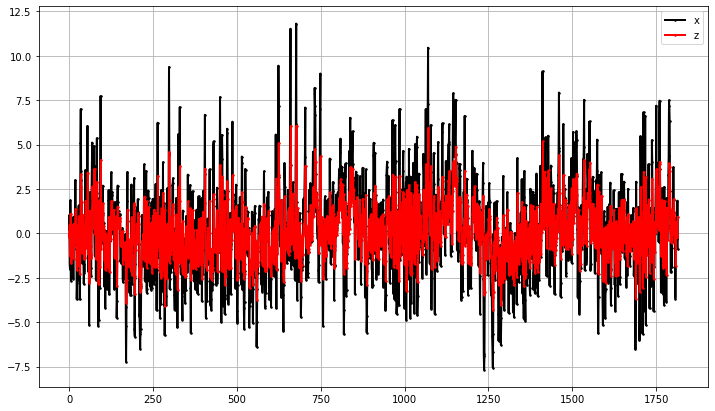

In [81]:
test_X = build_X(test_x, M)
predicted = test_X @ theta.T


# Plotting
plt.figure(figsize=(12, 7))
plt.plot(test_x[M:], c='k', label='x', marker='.', markersize=3, linewidth=2)
plt.plot(predicted, c='r', label='z', marker='.', markersize=3, linewidth=2)
plt.legend()
plt.grid()

- (Bonus) How valuable is your model for real time prediction? Try to perform honest time-marching with your model starting from $x_{M+1}$ to $x_{M+100}$. Is it still good? Try to choose the best parameters $M$ and $\lambda$.


In [82]:
# Your solution is here

# Problem 2 (Theoretical tasks)  (31 pts)

_1._
- (1 pts) what are the constants $C_1$ and $C_2$ such that $C_1 \|x\|_{\infty} \leq \|x\|_2 \leq C_2 \| x\|_{\infty}$
- (5 pts) Prove that $\| U A \|_F = \| A U \|_F = \| A \|_F$ for any unitary matrix $U$.
- (5 pts) Prove that $\| U A \|_2 = \| A U \|_2 = \| A \|_2$ for any unitary matrix $U$.
  
_2._
- (5 pts) Using the results from the previous subproblem, prove that $\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$. _Hint:_ SVD will help you.
- (5 pts) Show that for any $m, n$ and $k \le \min(m, n)$ there exists $A \in \mathbb{R}^{m \times n}: \mathrm{rank}(A) = k$, such that $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$. In other words, show that the previous inequality is not strict.
- (5 pts) Prove that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$.
- (5 pts) Prove that $\| A B \|_F \le \| A \|_2 \| B \|_F$.

**1.1)** What are the constants $C_1$ and $C_2$ such that $C_1 \|x\|_{\infty} \leq \|x\|_2 \leq C_2 \| x\|_{\infty}$

Let $x$ be a vector, $n$ is its size.

$\|x\|_{\infty} = \max\limits_i |x_i|, \|x\|_2 = \sqrt{ \sum_i x_i^2 }$

$(\max\limits_i |x_i|)^2 \leq x_1^2 + x_2^2 + ... + x_n^2 \leq n((\max\limits_i |x_i|)^2)$, therefore such constans are $C_1 = 1$ and $C_2 = \sqrt n$

**1.2)** Prove that $\| U A \|_F = \| A U \|_F = \| A \|_F$ for any unitary matrix $U$

$\| U A \|_F = tr(A^*U^*UA) = tr(A^*A) = \|A\|_F$ 

$\| A U \|_F = tr(U^*A^AU) = tr(UU^*A^*A) = \|A\|_F$ 

$\| U A \|_F = \| A \|_F = \| A U \|_F $

**1.3)** Prove that $\| U A \|_2 = \| A U \|_2 = \| A \|_2$ for any unitary matrix $U$

Let's first show that $\| Ux \|_2 = \| x \|_2$ for any unitary matrix $U$ and vector x

$\| UA \|_2 = \sup\limits_{x \neq 0} \frac{\|UAx\|_2}{\| x \|_2}$

Since $\| . \|_2$ vector norm is invariant to multiplication by an unitary matrix, we have $\|U(Ax)\|_2 = \|Ax\|_2$, and therefore 

$\| UA \|_2 = \sup\limits_{x \neq 0} \frac{\|UAx\|_2}{\| x \|_2} = \sup\limits_{x \neq 0} \frac{\|Ax\|_2}{\| x \|_2} = \| A \|_2$

$\| AU \|_2 = \sup\limits_{x \neq 0} \frac{\|AUx\|_2}{\| x \|_2}$

Let's consider new vector $y=Ux$. As shown above $\| y \|_2 = \|Ux\|_2 = \| x \|_2$, therefore

$\| AU \|_2 = \sup\limits_{x \neq 0} \frac{\|AUx\|_2}{\| x \|_2} = \sup\limits_{x \neq 0} \frac{\|Ay\|_2}{\| y \|_2} = \| A \|_2$

$\| U A \|_2 = \| A \|_2 = \| A U \|_2 $

**2.1)** Using the results from the previous subproblem, prove that $\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$.

Let's consider an SVD decomposition of the matrix $A$: $A = U \Sigma V^*$. As shown in **1.2** $\| A \|_F = \| U \Sigma V^* \|_F = \| \Sigma \|_F$ since $U$ and $V^*$ are unitary matricies.

$\| A \|_F = \| \Sigma \|_F = \sqrt{\sum\limits_{1}^{rank(A)} \sigma_i} \leq \sqrt{rank(A) \sigma_1} = \sqrt{rank(A)} \| A \|_2$

**2.2)** Show that for any $m, n$ and $k \le \min(m, n)$ there exists $A \in \mathbb{R}^{m \times n}: \mathrm{rank}(A) = k$, such that $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$. In other words, show that the previous inequality is not strict.

Let's consider such matrix $A \in \mathbb{R}^{m \times n}$ of rank $k$, which has same singular values all equal to 1. For example, it can be zero-filled matrix with $\mathrm{rank}(A)$ ones standing on the diagonal. For such matrix: $\| A \|_F = \| \Sigma \|_F = \sqrt{\sum\limits_{1}^{rank(A)} \sigma_i} = \sqrt{\sum\limits_{1}^{rank(A)} 1} = \sqrt{rank(A)} = \sqrt{rank(A)} \| A \|_2$

**2.3)** Prove that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$

$\| A \|_F = \| \Sigma \|_F = \sqrt{\sum\limits_{1}^{rank(A)} \sigma_i} = \sqrt{\sigma_1} = \| A \|_2$

**2.4)** Prove that $\| A B \|_F \le \| A \|_2 \| B \|_F$.

Let $b_i$ be the i-th column of matrix $B$

Then, according to the definition of Frobenius norm $\| A \| = \sqrt{\sum\limits_{i=1}^m\sum\limits_{j=1}^n a_{ij}}$

$\|AB\|_F = \sqrt{\sum\limits_{j=1}^{n} \|Ab_j\|_2^2}$

$\frac{\|Ax\|}{\|x\|} \leq \|A\|_2$, therefore

$\|AB\|_F = \sqrt{\sum\limits_{j=1}^{n} \|Ab_j\|_2^2} \leq \|A\|_2 \sqrt{\sum\limits_{j=1}^{n} \|b_j\|_2^2} = \|A\|_2\|B\|_F$

# Problem 3 (Matrix calculus) (15 pts)

_1._ (5 pts) Consider the following function

$$ F(U, V) = \frac{1}{2}\|X - UV\|_F^2, $$

where $X \in \mathbb{R}^{n \times n}$, $U \in \mathbb{R}^{n \times k}$ and $V \in \mathbb{R}^{k \times n}$ and $k < n$. 

- (2 pts) Derive analytical expression for the gradient of the function $F$ with respect to $U$ 
- (2 pts) Derive analytical expression for the gradient of the function $F$ with respect to $V$
- (1 pts) Estimate computational complexity of computing these gradients (in big-O notation). 

_2._ (2 pts) Derive analytical expression for the gradient of the function $f$:

$$ R(x) = \frac{(Ax, x)}{(x, x)}, $$

where $A$ is a symmetric real matrix. Why the gradient of this function is important in NLA you will know in the lectures later.

_3._ (8 pts) Consider the following function $f$ 

$$f(w) = \log\det\left(\sum_{i=1}^m w_i x_i x_i^{\top}\right),$$

where $x_i, \; i = 1,\dots,m$ are given column vectors. 


- (3 pts) Derive analytical expression for the gradient of $f$
- (1 pts) For what values of $m$ and vectors $x_i$ the function $f$ makes sense and is finite?
- (4 pts) Consider two approaches to compute it: directly with matrix products and so on and the single-line solution with ```einsum``` function.   
Generate some set of vectors $x_i \in \mathbb{R}^{1000}$ such that the funtion $f$ is finite and compare the time of computing derived gradient with these approaches. Use [%timeit](https://docs.python.org/3.6/library/timeit.html) command to measure time. What do you think about the reason of such behaviour? 

**1.1)** $\nabla_UF-?:$  $d(F(U, V)) = d(\frac{1}{2}\|X - UV\|_F^2) = \frac{1}{2}d(\langle X - UV, X - UV\rangle) = \frac{1}{2}( \langle d(X - UV), X - UV\rangle + \langle X - UV, d(X - UV)\rangle) = \langle X - UV, -d(U)V\rangle = \langle -(X- UV)V^T, d(U)\rangle,\, \,=> \, \nabla_UF = (UV-X)V^T$

**1.2)** $\nabla_VF-?:$  $d(F(U, V)) = d(\frac{1}{2}\|X - UV\|_F^2) = \frac{1}{2}d(\langle X - UV, X - UV\rangle) = \frac{1}{2}( \langle d(X - UV), X - UV\rangle + \langle X - UV, d(X - UV)\rangle) = \langle X - UV, -Ud(V)\rangle = \langle -U^T(X- UV), d(V)\rangle,\, \,=> \, \nabla_VF = U^T(UV-X)$

**1.3)** Since it is a bunch of matrix multiplications, the computation complekxity is the one of matrix multiplication. For example, in naive matrix multiplication it will be $O(n^2k)$

**2.1)** $d(R(x)) = d\left(\frac{(Ax, x)}{(x, x)} \right) = \frac{(x, x)d(Ax, x) - (Ax, x)d(x, x)}{(x, x)^2} = \frac{(x, x)((Ax, dx) + (A^Tx, dx)) - 2((Ax, x)x, dx)}{(x, x)^2} = \frac{2(x, x)(Ax, dx) - 2((Ax, x)x, dx)}{(x, x)^2}, \,$ therefore $\nabla_x R(x) = 2\frac{(x, x)Ax- (Ax, x)x}{(x, x)^2}$

**3.1)**

Since in **3.3** vectors $x_i$ are generated as $x_i \in \mathbb{R}^{1000}$, from now on we assume that $x_i$ are real.

Let $A = \sum_\limits{i=1}^m w_i x_i x_i^{T}$, a real matrix.

As was shown on the seminar $d(\det(X)) = \det(A) \langle A^{-T}, d(A) \rangle$, therefore

$d(f) = d(log(\det(A))) = \frac{1}{\det(A)}d(\det(A)) = \frac{1}{\det(A)} \det(A) \langle A^{-T}, d(A) \rangle = \langle A^{-1}, d(A) \rangle$ because $A$ is symmetric

Let's consider a partial derrivative first:
 
$\frac{d}{d \omega_i}f(\omega) = \langle A^{-1}, d\omega_i x_i x_i^T \rangle = \langle x_i^T A^{-1} x_i, d\omega_i \rangle$, therefore:

$\frac{\partial}{\partial \omega_i}f(\omega) =  x_i^T A^{-1} x_i$

$\nabla_w f(\omega) = \begin{pmatrix}
\ x_1^T A^{-1} x_1\\
.\\
.\\
.\\
x_m^T A^{-1} x_m\\
\end{pmatrix}$

**3.2)** Let $n$ be length of vectors $v_i$. $f$ makes sence if $\det(A)$ under the logarithm $\neq 0$

$\det(xx^T) = 0$ if $m = 1$ and $n > 1$. Hence, $m > 1$

Let's show that $f$ makes sence if we $\omega_i \neq 0 \forall i$, $m = n$ and $x_i$ are independent. Then $\det(A) \neq 0$ iff $rank(A) = n$. $rank(A) = n$ iff $Ay = 0$ only if $y = 0$

$Ay = \left(\sum_{i=1}^m w_i x_i x_i^{\top}\right) y = \sum_{i=1}^m w_i x_i \langle x_i, y \rangle = 0$ iff $w_i \langle x_i, y \rangle = 0 \, \forall i \in 1..n$. Since $x_i$ are independent and $\omega_i \neq 0 \forall i$ this is true iff $y = 0$

In [83]:
#3.3
import numpy as np


m = 1000
x = np.array([np.random.ranf(m) for _ in range(m)])
x = x - x*np.eye(m)
w = np.random.rand(m)
np.linalg.matrix_rank(x)

1000

In [84]:
A = np.zeros((m, m))
for i, w_i in enumerate(w):
    A += w_i * np.outer(x[i], x[i])
# assert np.linalg.det(A) == 0
np.linalg.det(A) == 0

/home/litleo/miniconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


False

In [85]:
A = np.zeros((m, m))
for i, w_i in enumerate(w):
    A += w_i * np.outer(x[i], x[i])
A = np.linalg.inv(A)

nabla_np = np.array([x_i.T @ A @ x_i for x_i in x])

In [86]:
%%timeit -r 1 -n 2
A = np.zeros((m, m))
for i, w_i in enumerate(w):
    A += w_i * np.outer(x[i], x[i])
A = np.linalg.inv(A)

nabla_np = np.array([x_i.T @ A @ x_i for x_i in x])

3.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)


In [88]:
nabla_ein = np.einsum('k, ik,  jk -> ij', w, x, x)
(nabla_np == nabla_ein).sum() - 1000*1000

-1000000

# Problem 4. Compression of the fully-connected layers in neural network with simple architecture (20 pts)

In this problem we consider the neural network that performs classification of the dataset of images. 
Any neural network can be considered as composition of simple linear and non-linear functions.
For example, a neural network with 3 layers can be represented as 

$$f_3(f_2(f_1(x, w_1), w_2), w_3),$$

where $x$ is input data (in our case it will be images) and $w_i, \; i =1,\dots,3$ are parameters that are going to be trained. 

We will study the compression potential of neural network with simple architecture: alternating some numbers of linear and non-linear functions. 

The main task in this problem is to study how the compression of fully-connected layers affects the test accuracy.
Any fully-connected layer is represented as linear function $AX + B$, where $X$ is input matrix and $A, B$ are trainable matrices. Matrices $A$ in every layer are going to be compressed.
The main result that you should get is the plot of dependence of test accuracy on the total number of parameters in the neural network.

#### Zero step: install PyTorch

- Follow the steps in [official instructions](https://pytorch.org/get-started/locally/)

#### First step: download CIFAR10 dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Check what images are we going to classify

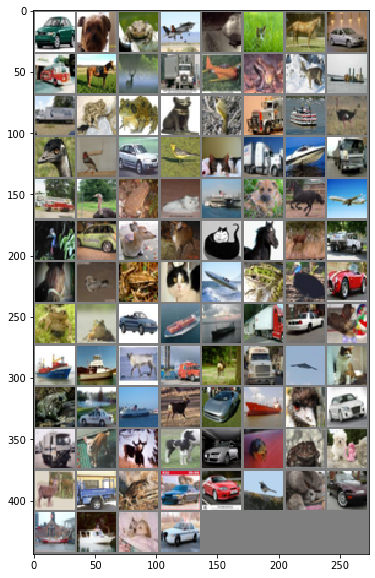

  car   dog  frog plane  bird   cat horse   car


In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


### Second step: neural network architecture

For simplicity and demonstration purposes of the neural network compression idea consider the architecture consisting of the only fully-connected layers and non-linear ReLU functions between them.
To demonstrate compression effect, consider the dimension of the inner layers equals to 1000.

Below you see implementation of such neural network in PyTorch.
More details about neural networks you will study in the *Deep learning* course in one of the upcoming term

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)
        x = self.ReLU(x)
        x = self.fc5(x)
        x = self.ReLU(x)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

#### Implement functions for training and testing after every sweep over all dataset entries

In [4]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [5]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Set parameters for training and print intermediate loss values

In [6]:
log_interval = 50
epochs = 7

### Third step: run training with the [Adam](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document) optimization method

If your laptop is not very fast, you will wait some time till training is finished. 

In [7]:
from tqdm import trange, tqdm_notebook

In [8]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in tqdm_notebook(range(1, epochs + 1)):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301425
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.932227
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.890782
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.771637
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.863316
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.838617
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.763521
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.760884
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.700178
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.524912

Test set: Average loss: 1.5903, Accuracy: 4414/10000 (44%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.655740
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.501494
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.668457
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.324508
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.369073
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.246714
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.346508
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.387725
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.379984
T

Now we have somehow trained neural network and we are ready to perform compression of the weigths in the fully-connected layers.

- (3 pts) Compute SVD of the matrix $1000 \times 1000$, which corresponds to a weight matrix $A$ in any layer of the trained neural network of the appropriate dimension. To find more information about accessing this matrix please refer to [PyTorch manual](https://pytorch.org/docs/stable/index.html).
Plot decaying of the singular values like it was shown in the lecture. What conclusion can you make?
- (12 pts) Create a new model, which is analogue to the class ```Net```, but with some significant distinctions. 
It takes as input parameters the instance of the class ```Net``` and compression rank $r > 0$. 
After that, this model has to compress all matrices $A$ in fully-connected layers with SVD using first $r$ singular vectors and singular values.
Pay attention to efficiently storing of compress representation of the layers.
Also ```forward``` method of your new model has to be implemented in a way to use compressed representation of the fully-connected layers. In all other aspects it has to reproduce ```forward``` method in the original non-compressed model (number of layers, activations, loss function etc).
- (5 pts) Plot dependence of test accuracy on the number of parameters in the compressed model. This number of parameters obviously depends on the compression rank $r$.
Also plot dependence of time to compute inference on the compression rank $r$.
Explain obtained results.
To measure time, use [%timeit](https://docs.python.org/3.6/library/timeit.html) with necessary parameters (examples of using this command see in lectures) 

In [9]:
model.fc1.weight.data.shape

torch.Size([1000, 3072])

In [10]:
u, s, v = torch.svd(model.fc1.weight.data)
s = s.numpy()

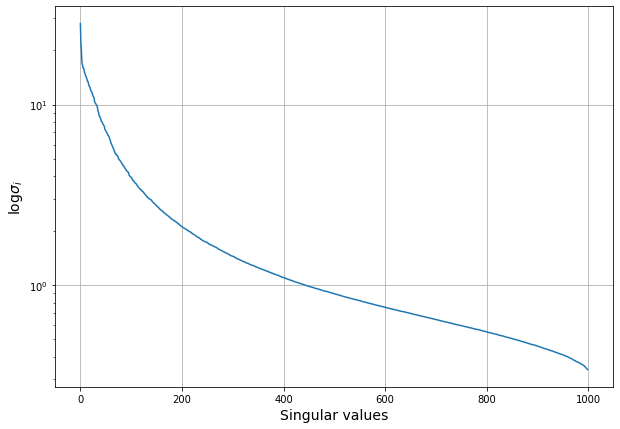

In [11]:
plt.figure(figsize=(10, 7))
plt.semilogy(s)
plt.ylabel(r'$\log{\sigma_i}$', fontsize=14)
plt.xlabel('Singular values', fontsize=14)
plt.grid()

In [30]:
class SVDCompressedNet(nn.Module):
    def __init__(self, model_instance, r):
        super(SVDCompressedNet, self).__init__()
        self.layers = []
        self.U_list, self.S_list, self.V_list = [], [], []
        for layer in list(model.modules())[2:-2]:
            U, S, V = torch.svd(layer.weight.data)
            
            V_trunc = V.T[:r, :]
            V_linear = nn.Linear(V_trunc.shape[0], V_trunc.shape[1], bias=False)
            V_linear.weight.data = V_trunc
            self.V_list.append(V_linear)
            
            S_r = torch.diag(S[:r])
            S_linear = nn.Linear(r, r, bias=False)
            S_linear.weight.data = S_r
            self.S_list.append(S_linear)
            
            U_trunc = U[:, :r]
            U_linear = nn.Linear(U_trunc.shape[0], U_trunc.shape[1])
            U_linear.weight.data = U_trunc
            U_linear.bias.data = layer.bias.data
            self.U_list.append(U_linear)
            
            
        self.fc1 = list(model_instance.modules())[1]
        self.fc6 = list(model_instance.modules())[-2]
        self.ReLU = nn.ReLU()
        
               
    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)
        for i in range(0, len(self.S_list)):
            x = self.V_list[i](x)
            x = self.S_list[i](x)
            x = self.U_list[i](x)
            x = self.ReLU(x)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)
    

def test_with_acc(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    return 100 * (correct/len(test_loader.dataset))

In [31]:
time_vals, accuracy_vals = [], []
r_vals = [int(i) for i in np.logspace(0, 3, 100)]
for r in tqdm_notebook(r_vals):
    t = %timeit -n 1 -r 1 -q -o ('test_with_acc(SVDCompressedNet(model, r), test_loader)')
    accuracy = test_with_acc(SVDCompressedNet(model, r), test_loader)
    time_vals.append(t)
    accuracy_vals.append(accuracy)

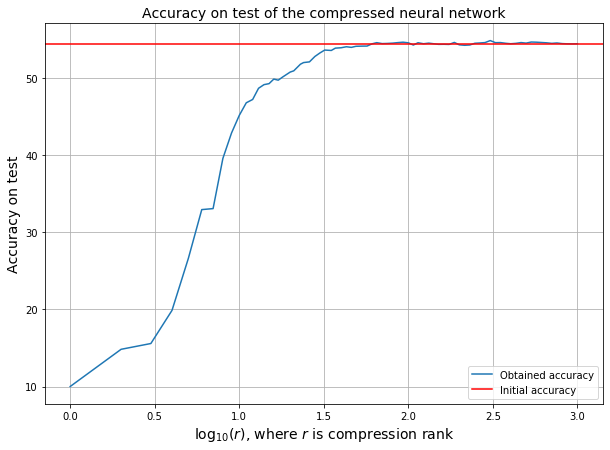

In [91]:
plt.figure(figsize=(10, 7))
plt.plot(np.log10(r_vals), accuracy_vals, label='Obtained accuracy')
plt.axhline(54.41, c='r', label='Initial accuracy')
plt.xlabel(r'$\log_{10}(r)$, where $r$ is compression rank', fontsize=14)
plt.ylabel('Accuracy on test', fontsize=14)
plt.title('Accuracy on test of the compressed neural network', fontsize=14)
plt.legend()
plt.grid()
plt.show()

As it can be seen starting from the compression rank of 100 the accuracy on test of the compressed net becomes indistinguishable from the one of the uncompressed net

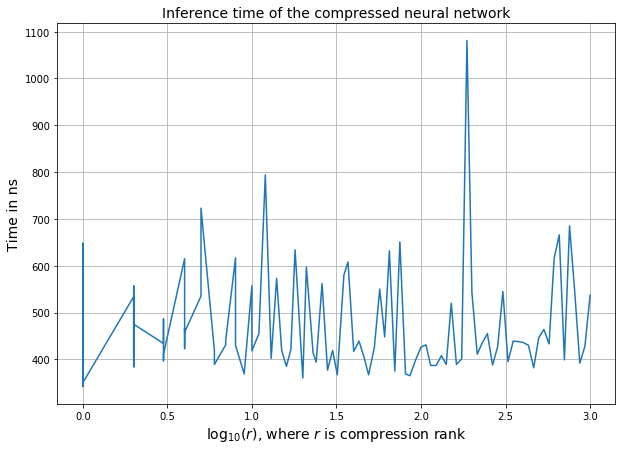

In [92]:
plt.figure(figsize=(10, 7))
plt.plot(np.log10(r_vals), [t.best * 1e9 for t in time_vals])
plt.xlabel(r'$\log_{10}(r)$, where $r$ is compression rank', fontsize=14)
plt.ylabel('Time in ns', fontsize=14)
plt.title('Inference time of the compressed neural network', fontsize=14)
plt.grid()
plt.show()

# Problem 5 (Bonus)

1. The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.

2. Write a function ```ranks_HOSVD(A, eps)```
that calculates Tucker ranks of a d-dimensional tensor $A$ using High-Order SVD (HOSVD) algorithm, where ```eps``` is the relative accuracy in the Frobenius norm between the approximated and the initial tensors. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.
```python
def ranks_HOSVD(A, eps):
      return r #r should be a tuple of ranks r = (r1, r2, ..., rd)
```